<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/bia/lab10/bia_exercises10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# exercise 1

import torch
import torch.nn as nn

input_tensor = torch.rand(1, 1, 7, 7)

conv_layer = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=(5, 6),
    stride=(3, 3),
    padding=(2, 1)
)

output_tensor = conv_layer(input_tensor)

print("Input Shape:", input_tensor.shape)
print("Output Shape:", output_tensor.shape)


Input Shape: torch.Size([1, 1, 7, 7])
Output Shape: torch.Size([1, 1, 3, 2])


In [2]:
# exercise 2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None

    def forward(self, X):
        Y = nn.ReLU()(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return nn.ReLU()(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [15]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))

In [26]:
net = nn.Sequential(b1, b2, b3,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(128, 10))

In [27]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.SVHN(
        root="../data", split="train", transform=trans, download=True)
    mnist_test = torchvision.datasets.SVHN(
        root="../data", split="test", transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [43257, 30000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [28]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [29]:
def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [30]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [31]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [32]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [33]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [34]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [35]:
batch_size, lr, num_epochs = 256, 0.9, 10
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat
Training on cuda:0
Epoch 1, Train loss 2.32, Train accuracy 20.30, Validation loss 1.86, Validation accuracy 33.32
Epoch 2, Train loss 1.10, Train accuracy 62.76, Validation loss 0.65, Validation accuracy 79.26
Epoch 3, Train loss 0.48, Train accuracy 84.75, Validation loss 0.48, Validation accuracy 85.13
Epoch 4, Train loss 0.36, Train accuracy 88.80, Validation loss 0.79, Validation accuracy 77.20
Epoch 5, Train loss 0.31, Train accuracy 90.73, Validation loss 0.36, Validation accuracy 88.79
Epoch 6, Train loss 0.26, Train accuracy 92.13, Validation loss 0.42, Validation accuracy 87.03
Epoch 7, Train loss 0.23, Train accuracy 93.09, Validation loss 0.34, Validation accuracy 90.03
Epoch 8, Train loss 0.20, Train accuracy 94.08, Validation loss 0.40, Validation accuracy 87.68
Epoch 9, Train loss 0.17, Train accuracy 94.70, Validation loss 0.39, Validation accuracy 88.8

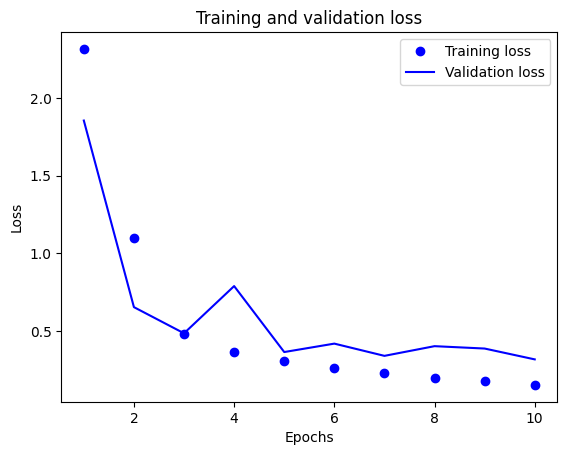

In [36]:
plot_loss(train_loss_all, val_loss_all)

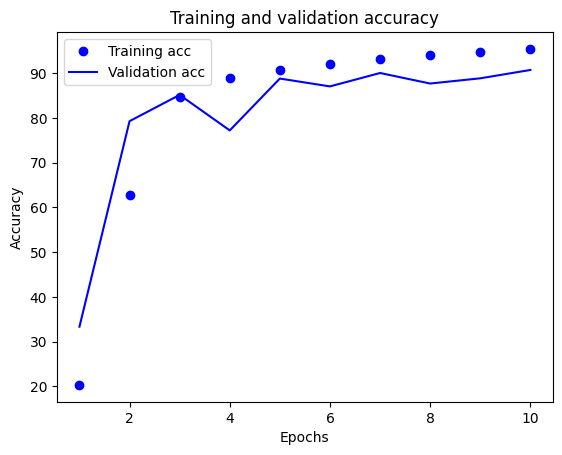

In [37]:
plot_accuracy(train_acc_all, val_acc_all)

In [46]:
class ConvolutionalBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.right_conv = nn.Conv2d(3, 32, kernel_size=3, padding = 1)
        self.right_relu = nn.ReLU()

        self.right_conv2 = nn.Conv2d(32, 3, kernel_size = 3, padding = 1)
        self.batchnorm = nn.BatchNorm2d(3)
        self.right_relu2 = nn.ReLU()

    def forward(self, input):
        input_copy = input

        right_output = self.right_conv(input)
        right_output = self.right_relu(right_output)
        right_output = self.right_conv2(right_output)
        right_output = self.batchnorm(right_output)
        right_output = self.right_relu2(right_output)

        output = input_copy + right_output

        return output

In [47]:
net = nn.Sequential(
    ConvolutionalBlock(),
    nn.Flatten(),
    # error multiplying mat1 and mat2
    # where mat1 is of shape 256 x bla
    nn.Linear(3*32*32, 10)
    )
net

Sequential(
  (0): ConvolutionalBlock(
    (right_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (right_relu): ReLU()
    (right_conv2): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (right_relu2): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=3072, out_features=10, bias=True)
)

In [40]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.SVHN(
        root="../data", split="train", transform=trans, download=True)
    mnist_test = torchvision.datasets.SVHN(
        root="../data", split="test", transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [43257, 30000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [48]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [49]:
def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [50]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [51]:
batch_size, lr, num_epochs = 256, 0.05, 5
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat
Training on cuda:0
Epoch 1, Train loss 6.26, Train accuracy 12.79, Validation loss 6.32, Validation accuracy 14.21
Epoch 2, Train loss 5.80, Train accuracy 12.94, Validation loss 6.41, Validation accuracy 18.97
Epoch 3, Train loss 5.81, Train accuracy 13.36, Validation loss 6.14, Validation accuracy 9.38
Epoch 4, Train loss 5.66, Train accuracy 13.62, Validation loss 6.58, Validation accuracy 19.11
Epoch 5, Train loss 5.50, Train accuracy 14.13, Validation loss 5.51, Validation accuracy 9.40
Test loss 5.74, Test accuracy 8.59


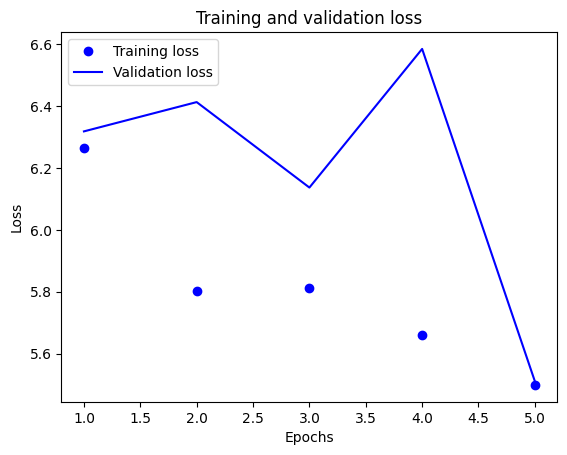

In [53]:
plot_loss(train_loss_all, val_loss_all)

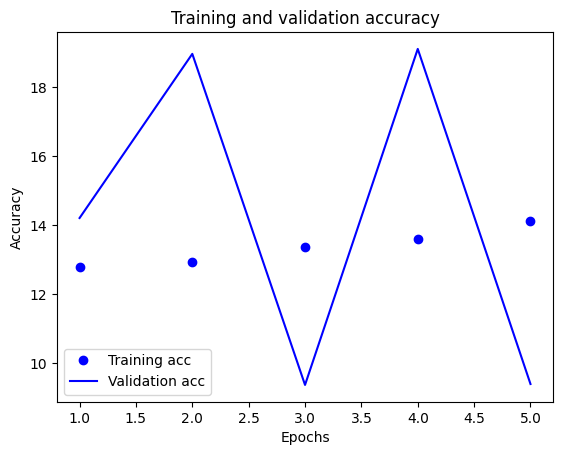

In [52]:
plot_accuracy(train_acc_all, val_acc_all)